https://huggingface.co/transformers/_modules/transformers/tokenization_utils_fast.html

https://github.com/huggingface/transformers/blob/master/examples/pytorch/question-answering/run_qa.py

In [ ]:
!pip install datasets
!pip install transformers

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from google.colab import drive
from datasets import load_dataset, load_metric
import sys
import os
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast, BertForSequenceClassification, BertConfig
from torch.utils.data import TensorDataset, DataLoader
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

In [3]:
!gdown --id '1mB5sTi65b2CsNWd130DSqTeke0rKnWVz' --output train_data.zip
!unzip -o train_data.zip

Downloading...
From: https://drive.google.com/uc?id=1mB5sTi65b2CsNWd130DSqTeke0rKnWVz
To: /content/train_data.zip
100% 1.34M/1.34M [00:00<00:00, 86.8MB/s]
Archive:  train_data.zip
  inflating: Train_risk_classification_ans_.csv  
  inflating: __MACOSX/._Train_risk_classification_ans_.csv  
  inflating: Train_qa_ans_.json      
  inflating: __MACOSX/._Train_qa_ans_.json  


In [4]:
train_qa_file = '/content/Train_qa_ans_.json'
train_cls_file = '/content/Train_risk_classification_ans_.csv'
df = pd.read_csv(train_cls_file)
df.columns.str.match("Unnamed")
df.loc[:,~df.columns.str.match("Unnamed")]
df.drop("Unnamed: 0",axis=1, inplace = True)

In [5]:
# df.drop('Unnamed: 0', inplace = True)
ratio = 0.9 # 9:1 
split = round(len(df)*ratio)
!mkdir -v ./meow
df[:split].to_csv('meow/train_cls.csv')
df[split:].to_csv('meow/valid_cls.csv')

mkdir: cannot create directory ‘./meow’: File exists


In [6]:
datasets = load_dataset("csv", data_files={"train":'meow/train_cls.csv', "validation": 'meow/valid_cls.csv'})

Using custom data configuration default-7baff3b0d5c96db8


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-7baff3b0d5c96db8/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


In [7]:
def prepare_features(examples):
        # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
        # in one example possible giving several features when a context is long, each of those features having a
        # context that overlaps a bit the context of the previous feature.
        args = (
            (examples['text'],))
        tokenized_examples  = tokenizer(
            *args, 
            truncation= True, 
            max_length= 512, # max_seq_length
            stride=200,   
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding= 'max_length',) # "max_length" 
       
        for key in  tokenized_examples:
          print(key, end = ':')
          value = tokenized_examples[key]
          print(len(value))
        # Since one example might give us several features if it has a long context, we need a map from a feature to
        # its corresponding example. This key gives us just that.
        sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
        # The offset mappings will give us a map from token to character position in the original context. This will
        # help us compute the start_positions and end_positions.
        offset_mapping = tokenized_examples.pop("offset_mapping")

        # Let's label those examples!
        
        tokenized_examples["labels"] = [] # 0 or 1 
        tokenized_examples["ids"] = []
        for i in range(len(tokenized_examples["input_ids"])):
            # Grab the sequence corresponding to that example (to know what is the context and what is the question).
            sequence_ids = tokenized_examples.sequence_ids(i)
            
            # One example can give several spans, this is the index of the example containing this span of text.
            sample_index = sample_mapping[i]
            tokenized_examples["ids"].append(examples["article_id"][sample_index])
            tokenized_examples['labels'].append(int(examples['label'][sample_index]))
        print(tokenized_examples["ids"])
        print(tokenized_examples["labels"] )
        return tokenized_examples

In [8]:
tokenized_train = prepare_features(datasets['train']) 
tokenized_valid = prepare_features(datasets['validation']) 
# can't use datasets.map 我猜是因為原本的dataset 是311 但是prepare features 會增加features數因此size對不起來

input_ids:1907
token_type_ids:1907
attention_mask:1907
offset_mapping:1907
overflow_to_sample_mapping:1907
[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 39, 39, 40, 

## 如果要塞進trainer:
### Part of run_glue.py ## 

1. datasets吃的方式要調整（不能用map）
line 381  
```
datasets = datasets.map(preprocess_function, batched=True, load_from_cache_file=not data_args.overwrite_cache)
```

```
train_seq = torch.tensor(tokenized_train['input_ids']) # 切斷的features
train_ids = torch.tensor(tokenized_train ['ids']) # 紀錄每個feature 對應到的原文章的article id 
train_y = torch.tensor(tokenized_train['labels'], dtype=torch.int64) # 紀錄該feature 原文章對應到的label 是0/1
train_mask = torch.tensor(tokenized_train ['attention_mask']) 
```


2. 改動line 416 



```
p: 'EvalPrediction' object with 2 fields: 
p.predictions
p.label_ids 
def compute_metrics(p: EvalPrediction):
        preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)
        if data_args.task_name is not None:
            result = metric.compute(predictions=preds, references=p.label_ids)
            # 
            if len(result) > 1:
                result["combined_score"] = np.mean(list(result.values())).item()
            return result
        elif is_regression:
            return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
        else:
            return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

```


In [9]:
from torch.utils.data import TensorDataset, DataLoader

# tokenized_train = prepare_features(datasets['train']) 
# tokenized_valid = prepare_features(datasets['validation'])

train_seq = torch.tensor(tokenized_train['input_ids']) # 切斷的features
train_ids = torch.tensor(tokenized_train ['ids']) # 紀錄每個feature 對應到的原文章的article id 
train_y = torch.tensor(tokenized_train['labels'], dtype=torch.int64) # 紀錄該feature 原文章對應到的label 是0/1
train_mask = torch.tensor(tokenized_train ['attention_mask']) 

v_seq = torch.tensor(tokenized_valid['input_ids']) # 切斷的features
v_ids = torch.tensor(tokenized_valid['ids']) # 紀錄每個feature 對應到的原文章的article id 
v_y = torch.tensor(tokenized_valid['labels'], dtype=torch.int64) # 紀錄該feature 原文章對應到的label 是0/1
v_mask = torch.tensor(tokenized_valid['attention_mask']) 


batch_size = 8
train_set = TensorDataset(train_seq, train_ids, train_y, train_mask)
valid_set = TensorDataset(v_seq, v_ids,v_y, v_mask)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle = False)

In [10]:
for i in train_loader:
  train_seq, train_ids, train_y, train_mask = i
  print(train_seq, train_seq.shape) # [batch_size, sequence_length]
  break
# [101]: CLS 

tensor([[ 101, 1048, 4554,  ..., 6206, 2897,  102],
        [ 101,  671, 1921,  ..., 4707, 8038,  102],
        [ 101, 4567, 1305,  ..., 3696, 4707,  102],
        ...,
        [ 101,  763, 4568,  ...,    0,    0,    0],
        [ 101, 1168,  749,  ..., 2552, 8043,  102],
        [ 101,  943, 5052,  ..., 8043, 3696,  102]]) torch.Size([8, 512])


In [11]:
import os
import random
import tensorflow as tf
myseed = 43
os.environ['PYTHONHASHSEED'] = str(myseed)
np.random.seed(myseed)
random.seed(myseed) 
tf.random.set_seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(myseed) 

## Training/Fine-tuning Bert
#### Source code reference:
https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

In [12]:
# Config
from transformers import AdamW
model = BertForSequenceClassification.from_pretrained('ckiplab/albert-base-chinese', output_hidden_states=True, num_labels = 3)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
optimizer = AdamW(model.parameters(), lr = 1e-5, weight_decay = 0.05)
epochs = 20

def cal_loss(pred, y): 
  '''L2 regularization'''
  l2_lambda = 0.0001
  l2_reg = 0
  for param in model.parameters():
    l2_reg += 0.5*(param**2).sum()
  loss_fn = nn.CrossEntropyLoss()
  loss = loss_fn(pred, y) + l2_lambda * l2_reg
  return loss

You are using a model of type albert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at ckiplab/albert-base-chinese were not used when initializing BertForSequenceClassification: ['albert.encoder.albert_layer_groups.0.albert_layers.0.attention.dense.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.ffn_output.weight', 'albert.embeddings.LayerNorm.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.ffn.weight', 'albert.embeddings.position_embeddings.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.weight', 'albert.encoder.embedding_hidden_mapping_in.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.LayerNorm.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.dense.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight', 'albert.encoder.albert_layer_group

In [13]:
from tqdm import tqdm

In [21]:

def train(dataloader = train_loader):
  model.train()
  losses, acc = 0, 0
  # iterate over batches
  for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    # set to train mode
    model.train()
    batch = [r.to(device) for r in batch]
    seq, id, label, mask = batch # train_seq, train_ids, train_y, train_mask

    # clear previously calculated gradients 
    model.zero_grad()        
    pred = model(seq, mask).logits

    _, pred2 = torch.max(pred, 1)
    loss = cal_loss(pred, label)
    loss.backward()
    # category_train, category_test
    acc += (pred2.cpu() == label.cpu()).sum().item()
    losses += loss.item()  
    
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
  
  avg_acc = acc / len(train_set)
  avg_loss = losses / len(dataloader)

  return avg_loss, avg_acc

In [25]:
def validate(dataloader = valid_loader):
  '''
  todo 要改成相同id的只計分一次
  但這個微麻煩，感覺把predictions, labels, ids拿出去外面算比較方便
  '''
  predictions = []
  labels = []
  article_ids = []

  model.eval()
  val_losses, val_acc = 0, 0
  for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    
    # push the batch to gpu

    seq, id, label, mask = batch
    seq = seq.to(device)
    mask = mask.to(device)
    label = label.to(device)
    ## id ##
    with torch.no_grad():
      pred = model(seq, mask).logits
      loss = cal_loss(pred, label)
      _, pred2 = torch.max(pred, 1)
      val_acc += (pred2.cpu() == label.cpu()).sum().item()
      val_losses += loss.item()
      
      predictions.extend(pred.cpu().tolist())
      labels.extend(label.cpu().tolist())
      article_ids.extend(id.tolist())
  
  avg_acc = val_acc / len(valid_set)
  avg_loss = val_losses / len(dataloader)
  
  return avg_loss, avg_acc, predictions, labels, article_ids

In [26]:
import time
best_acc = 0.
loss_dict = {'train': [], 'val': []}
acc_dict = {'train': [], 'val': []}
start = time.time()
for epoch in range(epochs):
    print(f'[{epoch+1}/{epochs}]')
   
    train_loss, train_acc = train()
    val_loss, val_acc, predictions, labels, ids = validate()
    
    # append training and validation loss
    loss_dict['train'].append(train_loss)
    loss_dict['val'].append(val_loss)
    acc_dict['train'].append(train_acc)
    acc_dict['val'].append(val_acc)
    print(f'Training acc:{train_acc:.3f}, Training Loss: {train_loss:.3f}')
    print(f'Validation acc:{val_acc:.3f}, Validation Loss: {val_loss:.3f}')

end = time.time()
print(f'Running {(end - start):.2f} seconds.')

  0%|          | 0/239 [00:00<?, ?it/s]

[1/20]


  0%|          | 0/239 [00:00<?, ?it/s]

Training acc:0.628, Training Loss: 3.535
Validation acc:0.576, Validation Loss: 3.530
[2/20]


  0%|          | 0/239 [00:00<?, ?it/s]

Training acc:0.637, Training Loss: 3.499
Validation acc:0.603, Validation Loss: 3.534
[3/20]


  0%|          | 0/239 [00:00<?, ?it/s]

Training acc:0.651, Training Loss: 3.464
Validation acc:0.562, Validation Loss: 3.589
[4/20]


  0%|          | 0/239 [00:00<?, ?it/s]

Training acc:0.674, Training Loss: 3.416
Validation acc:0.674, Validation Loss: 3.384
[5/20]


  0%|          | 0/239 [00:00<?, ?it/s]

Training acc:0.709, Training Loss: 3.375
Validation acc:0.661, Validation Loss: 3.359
[6/20]


  0%|          | 0/239 [00:00<?, ?it/s]

Training acc:0.704, Training Loss: 3.383
Validation acc:0.594, Validation Loss: 3.586
[7/20]


  0%|          | 0/239 [00:00<?, ?it/s]

Training acc:0.739, Training Loss: 3.327
Validation acc:0.629, Validation Loss: 3.373
[8/20]


  0%|          | 0/239 [00:00<?, ?it/s]

Training acc:0.765, Training Loss: 3.287
Validation acc:0.621, Validation Loss: 3.726
[9/20]


  0%|          | 0/239 [00:00<?, ?it/s]

Training acc:0.773, Training Loss: 3.235
Validation acc:0.665, Validation Loss: 3.388
[10/20]


  0%|          | 0/239 [00:00<?, ?it/s]

Training acc:0.808, Training Loss: 3.204
Validation acc:0.625, Validation Loss: 3.662
[11/20]


  4%|▍         | 9/239 [00:02<01:08,  3.34it/s]


KeyboardInterrupt: ignored

In [27]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
def plot_learning_curve(record, title ='', is_loss = True):
    total_steps = len(record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(record['train']) // len(record['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, record['train'], c='tab:cyan', label='train')
    plt.plot(x_2, record['val'], c='tab:green', label='val')
    
    plt.xlabel('Training steps')
    if is_loss:
      plt.ylim(0.0, 5.)
      plt.ylabel('Cross Entropy Loss')
    else:
      plt.ylim(0.0, 1.)
      plt.ylabel('Accuracy')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

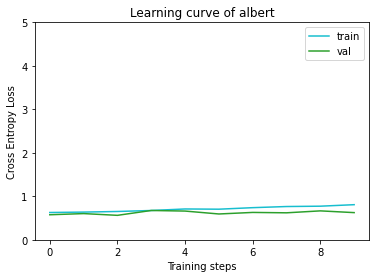

In [28]:
plot_learning_curve(acc_dict, title= 'albert', is_loss = True)

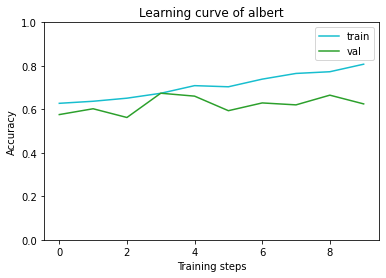

In [29]:
plot_learning_curve(acc_dict,  title= 'albert', is_loss = False)